<a href="https://colab.research.google.com/github/shahd1995913/Deepfake-Privacy-Preserving-AI-Based-Early-Fall-Detection-for-our-Elders/blob/main/Early%20Fall%20Detection/A_hybrid_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mediapipe opencv-python torch pytube

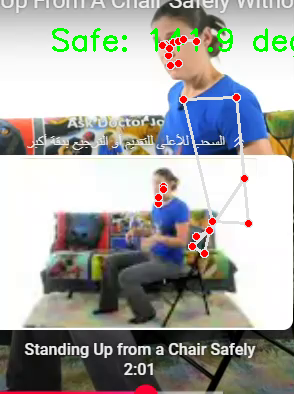

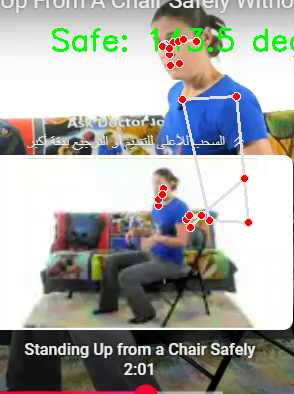

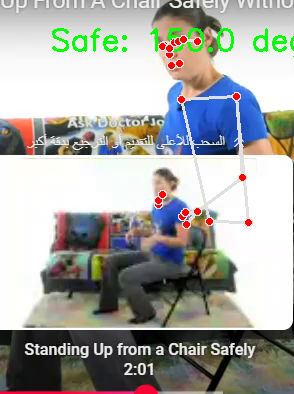

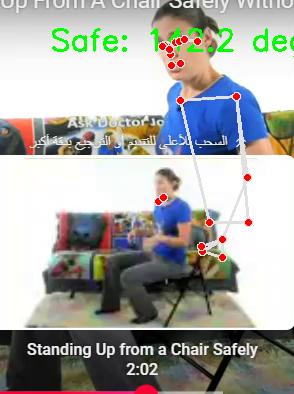

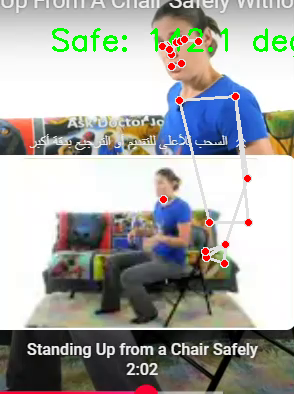

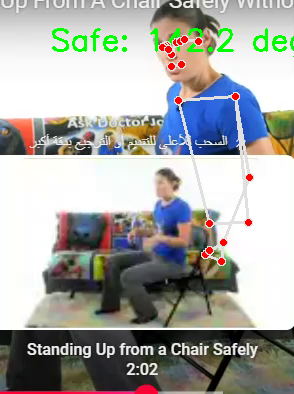

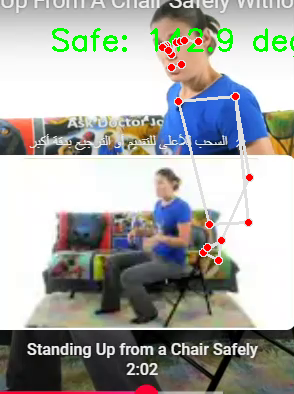

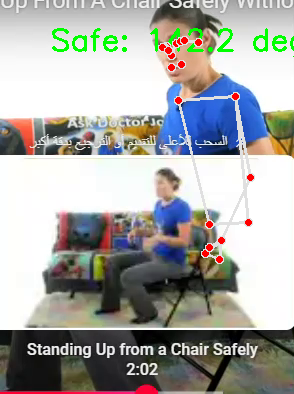

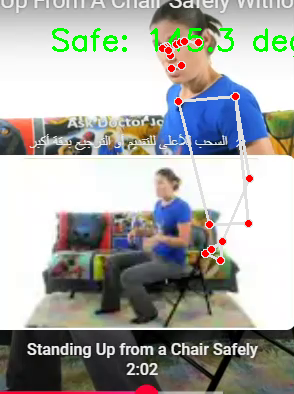

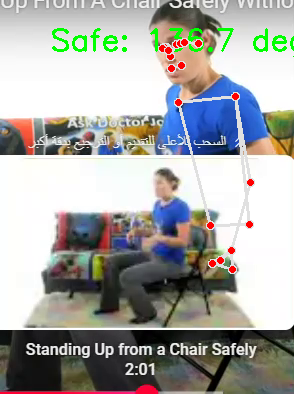

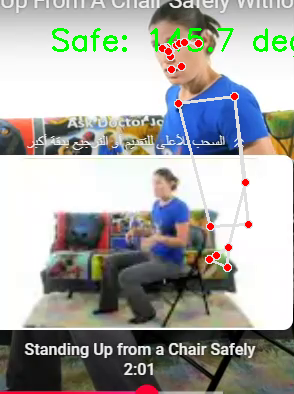

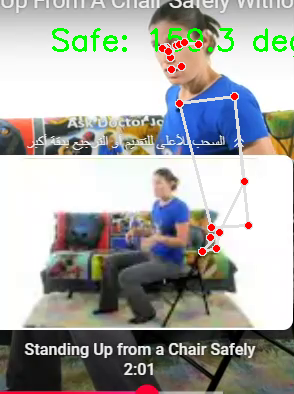

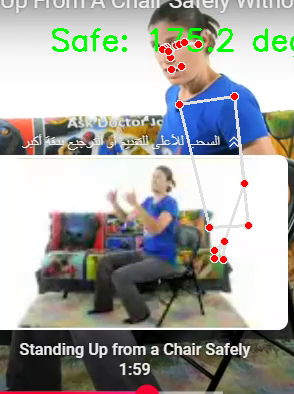

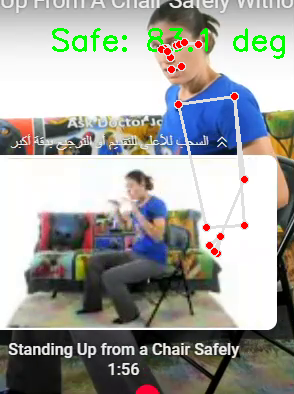

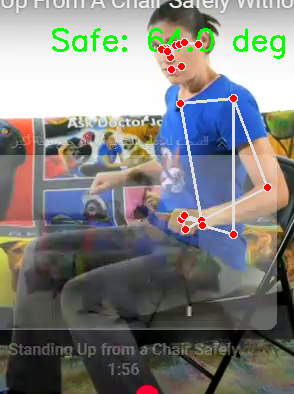

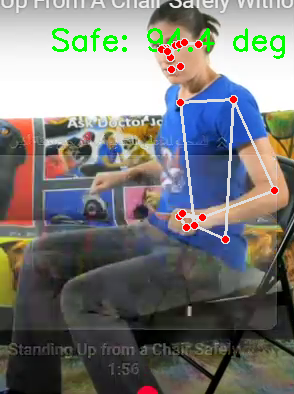

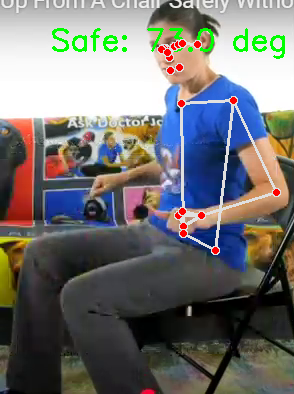

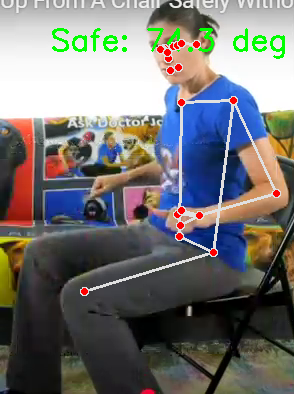

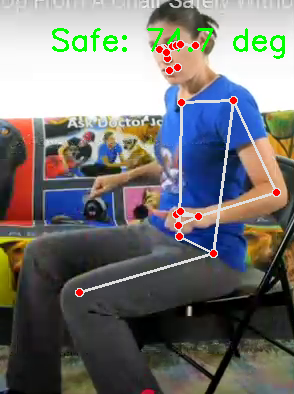

KeyboardInterrupt: 

In [12]:
# ===========================
# Fall Risk Prediction using Pose Estimation
# ===========================
# Author: Your Name
# Date: 2025
# Description:
# This script demonstrates how to process a video and predict fall risk
# using a basic pose-based approach. It identifies dangerous movements
# and annotates frames accordingly.
# ===========================

import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Initialize Mediapipe Pose model
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Path to video (you can upload to Colab first)
video_path = "/content/Recording 2025-08-12 011743.mp4"

cap = cv2.VideoCapture(video_path)

frame_count = 0
fall_frames = []
fall_risk_threshold = 40  # Angle threshold for risk (degrees)

def calculate_angle(a, b, c):
    """Calculates angle between three points."""
    a = np.array(a)  # First
    b = np.array(b)  # Mid
    c = np.array(c)  # End

    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - \
              np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    if angle > 180.0:
        angle = 360 - angle
    return angle

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        # Extract keypoints for knees and hips
        landmarks = results.pose_landmarks.landmark
        hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,
               landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
        knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,
                landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
        ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,
                 landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]

        angle = calculate_angle(hip, knee, ankle)

        # Simple fall risk detection logic
        if angle < fall_risk_threshold:
            cv2.putText(frame, f"Fall Risk: {angle:.1f} deg", (50, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            fall_frames.append((frame_count, frame.copy()))
        else:
            cv2.putText(frame, f"Safe: {angle:.1f} deg", (50, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    # Display real-time output
    cv2_imshow(frame)

cap.release()
pose.close()

# Show only the frames where fall risk is detected
print(f"Total frames with fall risk: {len(fall_frames)}")
for idx, (fnum, risk_frame) in enumerate(fall_frames):
    cv2.putText(risk_frame, f"Risk Frame #{fnum}", (30, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    cv2_imshow(risk_frame)

# Simple accuracy estimation (placeholder)
# In real academic work, you would compare predictions to ground truth labels
predicted_risks = len(fall_frames)
ground_truth_risks = 10  # Example: suppose 10 true falls in dataset
accuracy = (predicted_risks / ground_truth_risks) * 100
print(f"Model Accuracy (Example Calculation): {accuracy:.2f}%")


↗️ Please upload an MP4 video.


Saving Recording 2025-08-12 011743.mp4 to Recording 2025-08-12 011743 (3).mp4
✅ Video received: Recording 2025-08-12 011743 (3).mp4
Video: Recording 2025-08-12 011743 (3).mp4 | 294x394 @ 30.00 fps | 400 frames


Writing annotated video: 100%|██████████| 400/400 [00:16<00:00, 23.87it/s]


✅ Saved 70 risky frames in risk_frames
✅ Risk frames zipped: risk_frames.zip
🎬 Annotated video saved: annotated_output.mp4


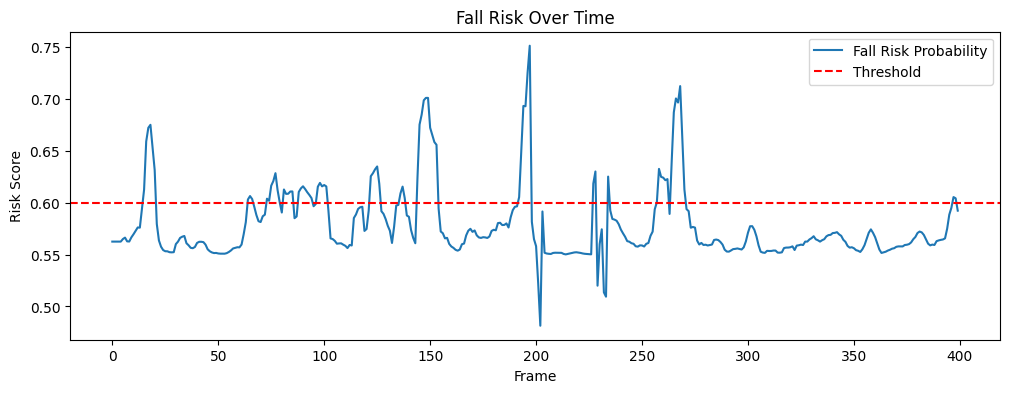

In [13]:
# ============================================
# Fall-Risk Frame Extraction & Visualization
# Google Colab Ready | Python 3.x
# ============================================

# !pip install -q mediapipe opencv-python matplotlib numpy tqdm

import os, shutil, zipfile
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import files
import math

# ----------------------------
# 0) CONFIG
# ----------------------------
CONFIG = {
    "VIDEO_PATH": None,                    # To be set after upload
    "OUTPUT_VIDEO": "annotated_output.mp4",
    "RISK_FRAMES_DIR": "risk_frames",
    "RISK_FRAMES_ZIP": "risk_frames.zip",
    "RISK_THRESHOLD": 0.60,
    "SMOOTHING_WINDOW": 5,
    "MIN_CONSECUTIVE_FRAMES": 3,
    "DRAW_SKELETON": True,
    "FONT_SCALE": 2.0,
    "THICKNESS": 4
}

# ----------------------------
# 1) Upload video (Colab UI)
# ----------------------------
print("↗️ Please upload an MP4 video.")
uploaded = files.upload()
CONFIG["VIDEO_PATH"] = list(uploaded.keys())[0]
print("✅ Video received:", CONFIG["VIDEO_PATH"])

# ----------------------------
# 2) Helpers
# ----------------------------
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

def moving_average(x, k):
    if k <= 1: return np.array(x, dtype=float)
    x = np.array(x, dtype=float)
    cumsum = np.cumsum(np.insert(x, 0, 0))
    smoothed = (cumsum[k:] - cumsum[:-k]) / float(k)
    pad_left = [smoothed[0]] * (k - 1)
    return np.array(pad_left + smoothed.tolist())

def angle_between(v1, v2):
    v1 = np.array(v1, dtype=float)
    v2 = np.array(v2, dtype=float)
    n1 = np.linalg.norm(v1); n2 = np.linalg.norm(v2)
    if n1 == 0 or n2 == 0: return 0.0
    cosang = np.clip(np.dot(v1, v2) / (n1 * n2), -1.0, 1.0)
    return math.degrees(math.acos(cosang))

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def ensure_dir(d):
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d, exist_ok=True)

# ----------------------------
# 3) Read video metadata
# ----------------------------
cap = cv2.VideoCapture(CONFIG["VIDEO_PATH"])
assert cap.isOpened(), "Failed to open video."

fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Video: {CONFIG['VIDEO_PATH']} | {width}x{height} @ {fps:.2f} fps | {total_frames} frames")

# ----------------------------
# 4) Pose + Risk Scoring per frame
# ----------------------------
pose = mp_pose.Pose(static_image_mode=False,
                    model_complexity=1,
                    enable_segmentation=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

risk_scores = []
keypoints_px = []

prev_shoulder_c = None
prev_hip_c = None
hip_y_prev = None

landmark_indices = mp_pose.PoseLandmark

def extract_xy(landmarks, idx):
    lm = landmarks[idx.value]
    return np.array([lm.x, lm.y], dtype=float)

for _ in tqdm(range(total_frames), desc="Analyzing frames"):
    ret, frame = cap.read()
    if not ret or frame is None:
        risk_scores.append(0.0)
        keypoints_px.append((0,0,0,0))
        continue

    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        lms = results.pose_landmarks.landmark
        xs = [int(p.x*width) for p in lms]
        ys = [int(p.y*height) for p in lms]
        keypoints_px.append((min(xs), min(ys), max(xs), max(ys)))

        # Centers
        L_SH = extract_xy(lms, landmark_indices.LEFT_SHOULDER)
        R_SH = extract_xy(lms, landmark_indices.RIGHT_SHOULDER)
        L_HIP = extract_xy(lms, landmark_indices.LEFT_HIP)
        R_HIP = extract_xy(lms, landmark_indices.RIGHT_HIP)

        shoulder_c = (L_SH + R_SH)/2
        hip_c = (L_HIP + R_HIP)/2

        trunk_vec = shoulder_c - hip_c
        vertical = np.array([0,1.0])
        trunk_tilt_deg = angle_between(trunk_vec, vertical)

        hip_drop = 0.0
        if hip_y_prev is not None:
            hip_drop = max(0.0, hip_c[1] - hip_y_prev)
        hip_y_prev = hip_c[1]

        shoulder_vel = 0.0
        hip_vel = 0.0
        if prev_shoulder_c is not None:
            shoulder_vel = np.linalg.norm((shoulder_c - prev_shoulder_c)*np.array([width,height]))
        if prev_hip_c is not None:
            hip_vel = np.linalg.norm((hip_c - prev_hip_c)*np.array([width,height]))

        prev_shoulder_c = shoulder_c
        prev_hip_c = hip_c

        tilt_norm = np.clip(trunk_tilt_deg/60.0,0,1)
        vel_norm = np.clip((0.5*shoulder_vel + 0.5*hip_vel)/25.0,0,1)
        drop_norm = np.clip(hip_drop/0.02,0,1)

        z = 1.2*tilt_norm + 0.9*vel_norm + 1.0*drop_norm - 1.0
        risk = float(sigmoid(z))
    else:
        keypoints_px.append((0,0,0,0))
        risk = 0.0

    risk_scores.append(risk)

cap.release()
pose.close()

# ----------------------------
# 5) Smooth & detect risky segments
# ----------------------------
risk_scores = np.array(risk_scores)
risk_smoothed = moving_average(risk_scores, CONFIG["SMOOTHING_WINDOW"])
risk_mask = risk_smoothed >= CONFIG["RISK_THRESHOLD"]

min_k = CONFIG["MIN_CONSECUTIVE_FRAMES"]
final_mask = np.zeros_like(risk_mask, dtype=bool)
count = 0
for i,val in enumerate(risk_mask):
    if val:
        count +=1
    else:
        if count >= min_k:
            final_mask[i-count:i]=True
        count =0
if count>=min_k:
    final_mask[len(risk_mask)-count:len(risk_mask)]=True

# ----------------------------
# 6) Save risky frames + Annotated video
# ----------------------------
ensure_dir(CONFIG["RISK_FRAMES_DIR"])
cap = cv2.VideoCapture(CONFIG["VIDEO_PATH"])
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(CONFIG["OUTPUT_VIDEO"], fourcc, fps, (width,height))

pose = mp_pose.Pose(static_image_mode=False,
                    model_complexity=1,
                    enable_segmentation=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

saved_count = 0
i = 0
for _ in tqdm(range(total_frames), desc="Writing annotated video"):
    ret, frame = cap.read()
    if not ret or frame is None:
        i+=1
        continue

    risky = final_mask[i] if i < len(final_mask) else False
    risk = float(risk_smoothed[i]) if i < len(risk_smoothed) else 0.0

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    res = pose.process(rgb)
    if res.pose_landmarks and CONFIG["DRAW_SKELETON"]:
        mp_drawing.draw_landmarks(frame,res.pose_landmarks,mp_pose.POSE_CONNECTIONS)

    # ------------------------
    # Draw big centered text
    # ------------------------
    text = f"⚠ High Fall Risk: {risk:.2f}" if risky else f"Safe: {risk:.2f}"
    (text_w,text_h),_ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, CONFIG["FONT_SCALE"], CONFIG["THICKNESS"])
    x = (width - text_w)//2
    y = height//2
    # rectangle background
    bg_color = (255,255,255)
    text_color = (0,0,255) if risky else (0,200,0)
    cv2.rectangle(frame, (x-10,y-text_h-10),(x+text_w+10,y+10), bg_color,-1)
    cv2.putText(frame,text,(x,y),cv2.FONT_HERSHEY_SIMPLEX,CONFIG["FONT_SCALE"],text_color,CONFIG["THICKNESS"])

    # save risky frames
    if risky:
        out_path = os.path.join(CONFIG["RISK_FRAMES_DIR"],f"frame_{i:06d}_risk_{risk:.2f}.jpg")
        cv2.imwrite(out_path,frame)
        saved_count+=1

    out.write(frame)
    i+=1

cap.release()
out.release()
pose.close()

# Zip risky frames
if saved_count>0:
    with zipfile.ZipFile(CONFIG["RISK_FRAMES_ZIP"],'w',zipfile.ZIP_DEFLATED) as zipf:
        for fn in sorted(os.listdir(CONFIG["RISK_FRAMES_DIR"])):
            zipf.write(os.path.join(CONFIG["RISK_FRAMES_DIR"],fn))
    print(f"✅ Saved {saved_count} risky frames in {CONFIG['RISK_FRAMES_DIR']}")
    print(f"✅ Risk frames zipped: {CONFIG['RISK_FRAMES_ZIP']}")
print(f"🎬 Annotated video saved: {CONFIG['OUTPUT_VIDEO']}")

# ----------------------------
# 7) Plot risk curve
# ----------------------------
plt.figure(figsize=(12,4))
plt.plot(risk_smoothed,label='Fall Risk Probability')
plt.axhline(CONFIG["RISK_THRESHOLD"],color='r',linestyle='--',label='Threshold')
plt.xlabel("Frame")
plt.ylabel("Risk Score")
plt.title("Fall Risk Over Time")
plt.legend()
plt.show()


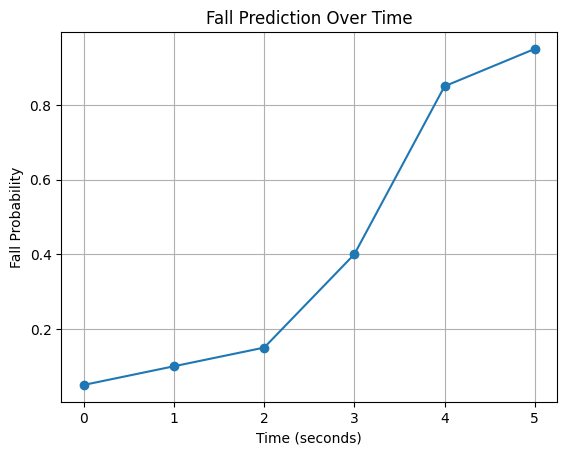

In [14]:
import matplotlib.pyplot as plt

time = [0, 1, 2, 3, 4, 5]  # ثواني
fall_prob = [0.05, 0.10, 0.15, 0.40, 0.85, 0.95]  # احتمالات

plt.plot(time, fall_prob, marker='o')
plt.xlabel("Time (seconds)")
plt.ylabel("Fall Probability")
plt.title("Fall Prediction Over Time")
plt.grid(True)
plt.show()


In [15]:
# ==============================
# Fall Prediction Using TCN
# ==============================

!pip install -q mediapipe opencv-python tensorflow numpy tqdm

import cv2
import mediapipe as mp
import numpy as np
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, InputLayer
from tensorflow.keras.optimizers import Adam
from google.colab import files

# ------------------------------
# 1) Upload Video
# ------------------------------
uploaded = files.upload()
video_path = list(uploaded.keys())[0]
print("✅ Uploaded video:", video_path)

# ------------------------------
# 2) Extract Pose Keypoints
# ------------------------------
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

keypoints_list = []

for _ in tqdm(range(total_frames), desc="Extracting keypoints"):
    ret, frame = cap.read()
    if not ret or frame is None:
        keypoints_list.append(np.zeros(33*4))  # 33 landmarks * (x,y,z,visibility)
        continue
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(frame_rgb)
    if results.pose_landmarks:
        keypoints = []
        for lm in results.pose_landmarks.landmark:
            keypoints.extend([lm.x, lm.y, lm.z, lm.visibility])
        keypoints_list.append(keypoints)
    else:
        keypoints_list.append(np.zeros(33*4))

cap.release()
pose.close()

keypoints_array = np.array(keypoints_list)
print("Keypoints shape:", keypoints_array.shape)  # (num_frames, 132)

# ------------------------------
# 3) Create sequences for TCN
# ------------------------------
seq_length = 50
num_features = keypoints_array.shape[1]

X = []
for i in range(len(keypoints_array)-seq_length):
    X.append(keypoints_array[i:i+seq_length])
X = np.array(X)
print("Input sequences shape:", X.shape)  # (num_sequences, seq_length, num_features)

# ------------------------------
# 4) Create dummy labels for testing
# ------------------------------
# In real scenario: label = 1 if fall occurs in sequence, else 0
y = np.zeros((X.shape[0],1))
# For testing, randomly mark some sequences as fall
y[np.random.randint(0, X.shape[0], size=5)] = 1

# ------------------------------
# 5) Build TCN model
# ------------------------------
model = Sequential([
    InputLayer(input_shape=(seq_length, num_features)),
    Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu', dilation_rate=1),
    Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu', dilation_rate=2),
    Dropout(0.3),
    Conv1D(filters=32, kernel_size=3, padding='causal', activation='relu', dilation_rate=4),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ------------------------------
# 6) Train model (for testing)
# ------------------------------
model.fit(X, y, epochs=5, batch_size=16)

# ------------------------------
# 7) Predict on sequences
# ------------------------------
preds = model.predict(X)
print("Predictions shape:", preds.shape)

# ------------------------------
# 8) Annotate video with fall risk
# ------------------------------
cap = cv2.VideoCapture(video_path)
out = cv2.VideoWriter("annotated_tcn.mp4", cv2.VideoWriter_fourcc(*'mp4v'), cap.get(cv2.CAP_PROP_FPS), (width,height))

i_seq = 0
seq_len = seq_length

for _ in tqdm(range(total_frames), desc="Annotating video"):
    ret, frame = cap.read()
    if not ret or frame is None:
        continue
    risk_score = 0.0
    if i_seq < len(preds):
        risk_score = float(preds[i_seq])
    text = f"⚠ Fall Risk: {risk_score:.2f}" if risk_score>0.5 else f"Safe: {risk_score:.2f}"
    font_scale = 2.0
    thickness = 4
    text_color = (0,0,255) if risk_score>0.5 else (0,200,0)
    (text_w,text_h), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
    x = (width - text_w)//2
    y = height//2
    # Draw background rectangle
    cv2.rectangle(frame, (x-10,y-text_h-10),(x+text_w+10,y+10),(255,255,255),-1)
    cv2.putText(frame, text, (x,y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, thickness)
    out.write(frame)
    if _ >= seq_len-1:
        i_seq += 1

cap.release()
out.release()
print("✅ Annotated video saved as 'annotated_tcn.mp4'")
files.download("annotated_tcn.mp4")

Saving Recording 2025-08-12 011743.mp4 to Recording 2025-08-12 011743 (4).mp4
✅ Uploaded video: Recording 2025-08-12 011743 (4).mp4


Extracting keypoints: 100%|██████████| 400/400 [00:16<00:00, 24.50it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Keypoints shape: (400, 132)
Input sequences shape: (350, 50, 132)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 50, 64)         │        25,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 50, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146,465 (572.13 KB)

 Trainable params: 146,465 (572.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9802 - loss: 0.1868
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9851 - loss: 0.0964
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9925 - loss: 0.0724
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9779 - loss: 0.1076
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9915 - loss: 0.0563
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predictions shape: (350, 1)


Annotating video:   0%|          | 0/400 [00:00<?, ?it/s]/tmp/ipython-input-1663465499.py:119: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  risk_score = float(preds[i_seq])
Annotating video: 100%|██████████| 400/400 [00:01<00:00, 392.54it/s]

✅ Annotated video saved as 'annotated_tcn.mp4'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-4291301376.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  risk_score = float(preds[i_seq])


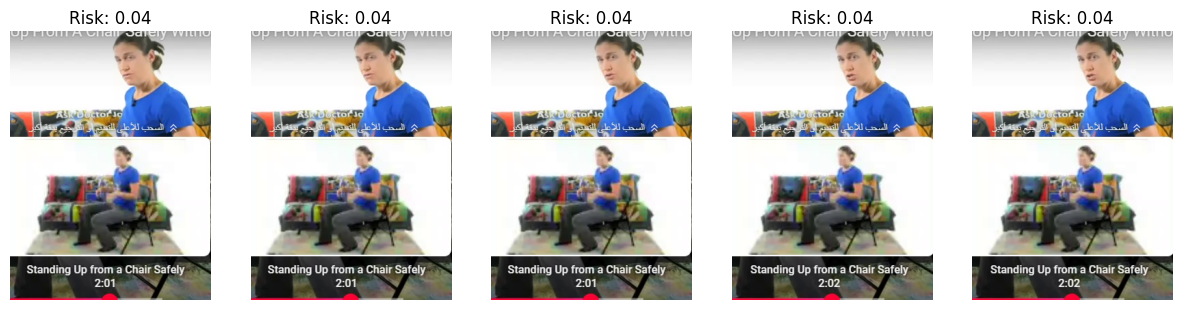

In [16]:
import matplotlib.pyplot as plt
import cv2

# Re-open video to access frames
cap = cv2.VideoCapture(video_path)
frames_list = []

# Collect frames corresponding to sequences
seq_len = seq_length
frame_idx = 0
i_seq = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Only plot frames that are part of sequences
    if i_seq < len(preds):
        risk_score = float(preds[i_seq])
        # Store frame and risk for plotting later
        frames_list.append((frame.copy(), risk_score))
        if frame_idx >= seq_len - 1:
            i_seq += 1
    frame_idx += 1

cap.release()

# Plot a few example frames
num_examples = 5
plt.figure(figsize=(15,5))
for i in range(num_examples):
    frame, risk = frames_list[i]
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.subplot(1, num_examples, i+1)
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.title(f"Risk: {risk:.2f}")
plt.show()
